In [1]:
import numpy as np
import pandas as pd

In [2]:
dof = 8
time_history = 2

In [3]:
# State #0 responses to fit ARX Model

state0 = pd.read_csv(
    f"datasets/state0_datasets/state0_acceleration_timehistory{time_history}.csv", index_col="Time"
)
state0

,m1,m2,m3,m4,m5,m6,m7,m8
Time,,,,,,,,
0.000,-1.526696,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.001,-1.675272,-0.018320,-0.002366,-0.001191,-0.000778,-0.000589,-0.000497,-0.000459
0.002,-1.876274,-0.056759,-0.005289,-0.002552,-0.001660,-0.001257,-0.001060,-0.000977
0.003,1.476609,-0.099500,-0.006697,-0.002825,-0.001816,-0.001369,-0.001152,-0.001062
0.004,2.404834,-0.114707,-0.006172,-0.001596,-0.000966,-0.000714,-0.000596,-0.000547
...,...,...,...,...,...,...,...,...
99.996,0.957024,0.729612,-0.240526,-0.916315,0.009186,-0.051639,0.001201,0.935629
99.997,-2.545549,0.763144,-0.049363,-0.951995,-0.147812,-0.038993,0.026383,0.991172
99.998,-1.419650,0.751069,0.136216,-0.967864,-0.311160,-0.027921,0.061612,1.034669


In [4]:
# Processing features data to fit ARX Model


def get_feature_df(state):
    features = state.copy()
    features.columns = [f"y{i+1}(k)" for i in range(dof)]
    for i in range(dof):
        features[f"y{i+1}(k-1)"] = features[f"y{i+1}(k)"].shift()
        features[f"y{i+1}(k-2)"] = features[f"y{i+1}(k)"].shift(2)
    features.drop(columns=[f"y{i+1}(k)" for i in range(1, dof)], inplace=True)
    features.dropna(inplace=True)
    return features


In [5]:
# Fitting ARX Model using LinearRegression for State #0 (Undamaged) all masses

from sklearn.linear_model import LinearRegression

features0 = get_feature_df(state0)
model_parameters = [] # list of fitted models | all masses | size = dof
for i in range(dof):
    model = LinearRegression().fit(features0.values,(state0[[f'm{i+1}']].values)[2:])
    model_parameters.append(model)

sigma0 = [] # STD of residual errors | all masses | size = dof
for i in range(dof):
    predicted = model_parameters[i].predict(features0.values)
    measured = (state0[[f'm{i+1}']].values)[2:]
    residual = measured - predicted
    sigma0.append(np.std(residual))

sigma0

[6.792085518284457e-15,
 4.508671755295735e-12,
 4.331510703367004e-12,
 4.32734159177994e-12,
 4.520141844515104e-12,
 4.51337054441956e-12,
 4.3375022051219126e-12,
 2.5499883770936535e-12]

In [6]:
# For damaged states (State #1-4)

sigma = np.zeros((4, dof))

for state in range(1,5):
    state_df = pd.read_csv(f"datasets/state{state}_datasets/state{state}_acceleration_timehistory{time_history}.csv", index_col="Time")
    features_df = get_feature_df(state_df)
    sigma_arr = []
    for i in range(dof):
        predicted = model_parameters[i].predict(features_df.values)
        measured = (state_df[[f'm{i+1}']].values)[2:]
        residual = measured - predicted
        sigma_arr.append(np.std(residual))
    sigma[state-1, :] = sigma_arr

sigma

array([[6.79184336e-15, 8.11485978e-06, 3.76176220e-04, 3.76921226e-04,
        3.08788294e-04, 3.08624370e-04, 4.74973117e-06, 3.56668479e-06],
       [6.79280162e-15, 1.68237664e-05, 7.74130567e-04, 7.75538775e-04,
        6.32647835e-04, 6.32241755e-04, 9.82714278e-06, 7.40571814e-06],
       [6.79469831e-15, 3.63220570e-05, 1.64207181e-03, 1.64440327e-03,
        1.31739122e-03, 1.31609543e-03, 2.10840752e-05, 1.60360358e-05],
       [6.79500030e-15, 1.19859417e-04, 4.76595756e-03, 4.76534311e-03,
        3.13528788e-03, 3.12520887e-03, 6.67757210e-05, 5.34336812e-05]])

In [7]:
# Ratios of STDs | all masses | all states

ratios = sigma / sigma0
ratios

array([[9.99964347e-01, 1.79983379e+06, 8.68464251e+07, 8.71022586e+07,
        6.83138505e+07, 6.83800205e+07, 1.09503833e+06, 1.39870629e+06],
       [1.00010543e+00, 3.73142410e+06, 1.78720687e+08, 1.79218293e+08,
        1.39961943e+08, 1.40081952e+08, 2.26562254e+06, 2.90421643e+06],
       [1.00038468e+00, 8.05604377e+06, 3.79099099e+08, 3.80003111e+08,
        2.91449088e+08, 2.91599241e+08, 4.86087941e+06, 6.28867015e+06],
       [1.00042914e+00, 2.65841967e+07, 1.10029915e+09, 1.10121723e+09,
        6.93625994e+08, 6.92433480e+08, 1.53949711e+07, 2.09544803e+07]])

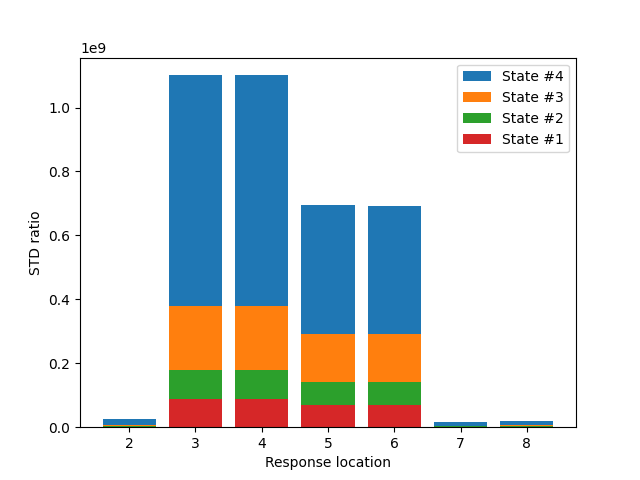

In [9]:
import matplotlib.pyplot as plt
%matplotlib widget

plt.bar([2,3,4,5,6,7,8], ratios[3, 1:], label = "State #4")
plt.bar([2,3,4,5,6,7,8], ratios[2, 1:], label = "State #3")
plt.bar([2,3,4,5,6,7,8], ratios[1, 1:], label = "State #2")
plt.bar([2,3,4,5,6,7,8], ratios[0, 1:], label = "State #1")
plt.xlabel("Response location")
plt.ylabel("STD ratio")
plt.legend()
plt.savefig("arx.svg")
plt.show()

In [9]:
features0 = get_feature_df(state0)
features0

,y1(k),y1(k-1),y1(k-2),y2(k-1),y2(k-2),y3(k-1),y3(k-2),y4(k-1),y4(k-2),y5(k-1),y5(k-2),y6(k-1),y6(k-2),y7(k-1),y7(k-2),y8(k-1),y8(k-2)
Time,,,,,,,,,,,,,,,,,
0.002,0.425029,-0.529888,1.570298,0.008007,0.000000,0.000781,0.000000,0.000389,0.000000,0.000253,0.000000,0.000192,0.000000,0.000162,0.000000,0.000149,0.000000
0.003,1.075054,0.425029,-0.529888,0.012274,0.008007,0.000836,0.000781,0.000366,0.000389,0.000236,0.000253,0.000178,0.000192,0.000150,0.000162,0.000138,0.000149
0.004,-0.016896,1.075054,0.425029,0.025154,0.012274,0.002222,0.000836,0.000949,0.000366,0.000611,0.000236,0.000461,0.000178,0.000388,0.000150,0.000358,0.000138
0.005,-1.861545,-0.016896,1.075054,0.045236,0.025154,0.003618,0.002222,0.001401,0.000949,0.000893,0.000611,0.000672,0.000461,0.000566,0.000388,0.000521,0.000358
0.006,-3.508702,-1.861545,-0.016896,0.054018,0.045236,0.003412,0.003618,0.000813,0.001401,0.000481,0.000893,0.000355,0.000672,0.000296,0.000566,0.000272,0.000521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99.996,1.613109,-2.332150,-1.040622,0.798886,0.856952,0.082243,0.078567,0.181885,0.137402,-0.277861,-0.383672,-0.238988,-0.147251,0.461192,0.545874,-0.532708,-0.613140
99.997,-0.156631,1.613109,-2.332150,0.714427,0.798886,0.097211,0.082243,0.220561,0.181885,-0.167303,-0.277861,-0.321068,-0.238988,0.358388,0.461192,-0.441535,-0.532708
99.998,-3.834090,-0.156631,1.613109,0.629511,0.714427,0.122037,0.097211,0.253950,0.220561,-0.055261,-0.167303,-0.391751,-0.321068,0.240250,0.358388,-0.342145,-0.441535


In [10]:
state0.describe()

,m1,m2,m3,m4,m5,m6,m7,m8
count,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000
mean,0.000506,0.000593,0.000521,0.000481,0.000459,0.000515,0.000550,0.000461
std,2.122105,0.582367,0.518890,0.485020,0.451530,0.427257,0.370493,0.499992
min,-10.313046,-2.332042,-2.070073,-1.871322,-1.804583,-1.611123,-1.329777,-1.891606
25%,-1.425112,-0.393055,-0.351046,-0.328678,-0.306236,-0.290592,-0.253510,-0.337383
50%,-0.005939,-0.001227,0.001836,0.005764,0.001779,-0.000945,0.001291,-0.000457
75%,1.435578,0.395497,0.350055,0.332840,0.308604,0.289484,0.252027,0.338857
max,8.879427,2.502642,2.126015,1.911548,1.947825,2.169143,1.474150,2.066230


In [11]:
cov = np.cov(state0.T)
cov


array([[ 4.50332968, -0.110076  , -0.13012725, -0.03741426, -0.03122985,
        -0.02569214, -0.01520515, -0.01621254],
       [-0.110076  ,  0.33915186,  0.01730247, -0.11761409, -0.04113506,
        -0.0203288 , -0.01882922, -0.02138989],
       [-0.13012725,  0.01730247,  0.26924726,  0.04181935, -0.09584578,
        -0.04253906, -0.02477834, -0.0254198 ],
       [-0.03741426, -0.11761409,  0.04181935,  0.23524468,  0.05679036,
        -0.08798595, -0.05436735, -0.02853353],
       [-0.03122985, -0.04113506, -0.09584578,  0.05679036,  0.20387905,
         0.05443968, -0.082278  , -0.06079367],
       [-0.02569214, -0.0203288 , -0.04253906, -0.08798595,  0.05443968,
         0.18254884,  0.05332748, -0.1100103 ],
       [-0.01520515, -0.01882922, -0.02477834, -0.05436735, -0.082278  ,
         0.05332748,  0.13726525,  0.01005327],
       [-0.01621254, -0.02138989, -0.0254198 , -0.02853353, -0.06079367,
        -0.1100103 ,  0.01005327,  0.24999214]])

In [12]:
from sklearn.decomposition import PCA

pca = PCA(8)
pca = pca.fit_transform(cov)
pcadf = pd.DataFrame(pca)
pcadf

,0,1,2,3,4,5,6,7
0,3.990382,0.005793,-0.003786,-0.006872,-0.000998,-0.000587,-0.000027,8.831818e-18
1,-0.635465,0.306670,0.031942,-0.075654,-0.134567,0.027898,0.001304,8.831818e-18
2,-0.655463,0.019015,-0.184197,-0.174653,0.090773,-0.049337,-0.002862,8.831818e-18
3,-0.553502,-0.261492,-0.095383,-0.059150,-0.048868,0.061613,0.005147,8.831818e-18
4,-0.544911,-0.167766,0.175563,0.005273,-0.112770,-0.037169,-0.007641,8.831818e-18
5,-0.540486,0.008506,0.225443,0.000526,0.110448,-0.025988,0.008702,8.831818e-18
6,-0.529926,0.059256,0.027815,0.090739,0.137802,0.060724,-0.007401,8.831818e-18
7,-0.530629,0.030018,-0.177397,0.219791,-0.041820,-0.037154,0.002777,8.831818e-18


In [13]:
import scipy.linalg as la

l, phi = la.eigh(cov)

l

array([0.01485112, 0.04825016, 0.1191047 , 0.27293696, 0.3137817 ,
       0.39776673, 0.44302747, 4.51093993])

In [14]:
eig = np.zeros((5,8))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for state in range(1,5):
    state_df = pd.read_csv(f"datasets/state{state}_datasets/state{state}_acceleration_timehistory{time_history}.csv", index_col="Time")
    cov = np.cov((state_df.values).T)
    lambd, phii = la.eigh(cov)
    eig[state, :] = lambd
    print(f"State {state}")
    print(lambd)
    ax.plot([1,2,3,4,5,6,7,8], lambd, label = f"State {state}")
ax.plot([1,2,3,4,5,6,7,8], l, label = "State 0")
ax.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

State 1
[0.01539101 0.04819366 0.12382594 0.28350628 0.31257884 0.3985656
 0.43631452 4.5109306 ]
State 2
[0.01551679 0.04814076 0.12783922 0.2905471  0.31446085 0.39814234
 0.43207275 4.51244104]
State 3
[0.01415077 0.04762036 0.1327289  0.28933056 0.31985169 0.39298691
 0.43396788 4.51805837]
State 4
[3.02769934e-03 4.12395823e-02 9.15655914e-02 2.14006832e-01
 2.31538157e-01 4.07361732e-01 5.50230583e-01 4.56493225e+00]
